# Tutorial 2b: Defining parameters and estimating them

*This tutorial was generated from an Jupyter notebook.  You can download the notebook [here](t2b_defining_and_estimating_parameters.ipynb).*

In [1]:
import warnings

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.special

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Seaborn, useful for graphics
import seaborn as sns

# Beeswarm plots
import beeswarm as bs

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [Tutorial 2a](t2a_managing_data_sets.html), we parsed the data set and set ourselves up for analysis.  In this tutorial, we will spend a lot of time discussing how best to characterize fish sleep.  We have extensive data about their movement, but how do we define when a fish is "sleeping" or not?  Or, if we do not want to make a Boolean determination of sleep, how to we quantify "wakefulness?"  

This step, in which we define the metrics we will use to compare sample, is often a crucial part of analyzing biological data.  This is really one of those areas where "there is no right way to do it."  These are design decisions, and we often rely on our experience and scientific prudence to make judgments.  There is nothing inherently wrong about this.  In the context of Bayes theorem as a model for learning, this is part of the "I" that always appears in the conditions of the probabilities.

As a reminder, we made a convenient tidy CSV file in our last tutorial, so we will load it into a `DataFrame`.

I also want my `pretty_activity_plot` function from Tutorial 1a.  If you saved it in a .py file, you can just import the module.  For convenience, I will just redfine it here.

In [2]:
def pretty_activity_plot(ax, selector, selection, col, df, xlabel='time (hr)', 
                         ylabel='activity (sec / min)', lw=0.25, 
                         color=None):
    """
    Makes a pretty plot of sleep traces.  Generates the plot on axes ax,
    and then returns the updated ax.
    """
    # Make sure selection input is iterable
    if type(selection) in [str, int, float]:
        selection = [selection]
        
    # Plot time traces of column col for each fish
    for sel in selection:
        # Pull out record of interest
        df_plot = df[df[selector]==sel]

        # Generate plot
        if color is None:
            ax.plot(df_plot.zeit, df_plot[col], '-', lw=lw)
        else:
            ax.plot(df_plot.zeit, df_plot[col], '-', lw=lw, color=color)

    # Label axes
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # Set axis limits
    ax.set_xlim((df_plot.zeit.min(), df_plot.zeit.max()))
    ax.set_ylim((0.0, ax.get_ylim()[1]))
    
    # Overlay night shading
    ax.fill_between(df_plot.zeit, 0.0, ax.get_ylim()[1], 
                    where=~df_plot.light, color='gray', alpha=0.3, zorder=0)    
    
    return ax

## Loading in the data

Let's fetch our nice, tidy `DataFrame`s!  Our main analysis will be with the activity summed over 10-minute intervals, so we'll call that one `df`.  We'll also look at the one-minute-interval data.  We'll call that one `df_dense`.

In [3]:
# Load the DataFrame from Tutorial 2a.
df = pd.read_csv('../data/gandhi_et_al/130315_10_minute_intervals.csv')
df_dense = pd.read_csv('../data/gandhi_et_al/130315_1_minute_intervals.csv')

## The bird's eye view

As we explore the data, it would be useful to see the variation from fish to fish.  We have 17 wild type fish, so we could just plot all of the traces on the same plot (using very thin lines) to get a view of what the plots look like relative to each other.
<!--To choose the colors, we want unique colors for all plots (since we only have 17, that's not too many).  We can use Seaborn's `color_palette()` function to generate the colors we want, and then plot using a context manager.  First, let's look at a good color palette to use, employing Seaborn's `palplot()` function.-->

This should work for us.  Let's make the plot!

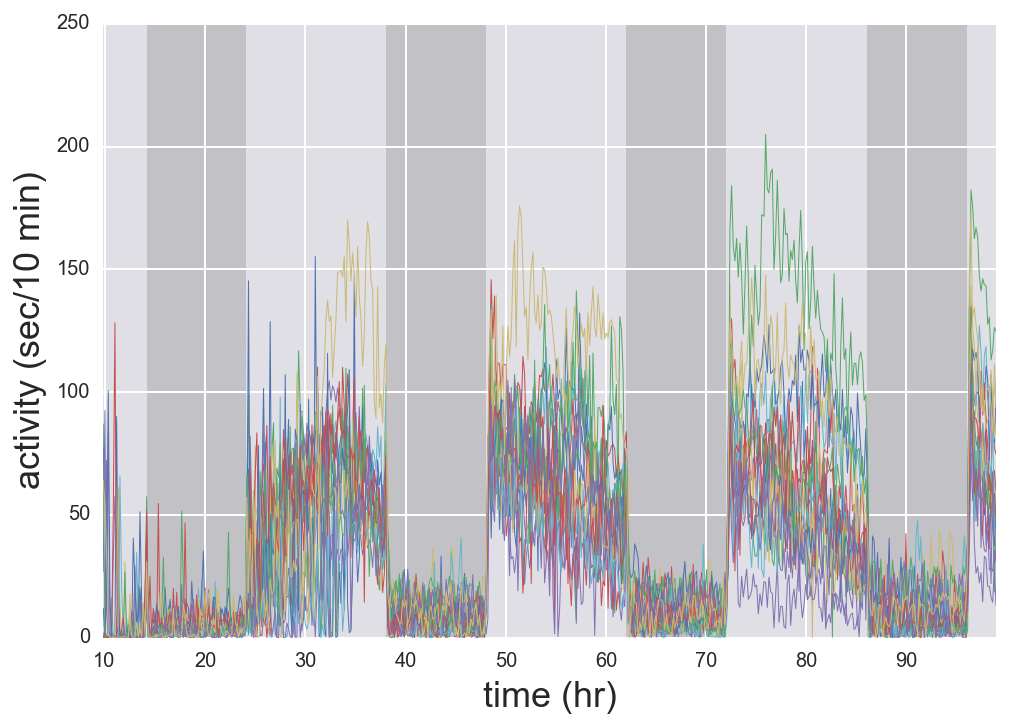

In [4]:
# To plot all the wild type fish, we pass all columns except zeit as y var.
fishes = df.fish[df.genotype=='wt'].unique()
fig, ax = plt.subplots()
ax = pretty_activity_plot(ax, 'fish', fishes, 'activity', df, lw=0.5, 
                          ylabel='activity (sec/10 min)')

This type of plot is useful because it illustrates all of the measurements that were done in the experiment.  It is not difficult to make.  While these types of plots are not often shown in the main text of papers, I think they are very nice to show in supplements.

Let's look at all three genotypes together.

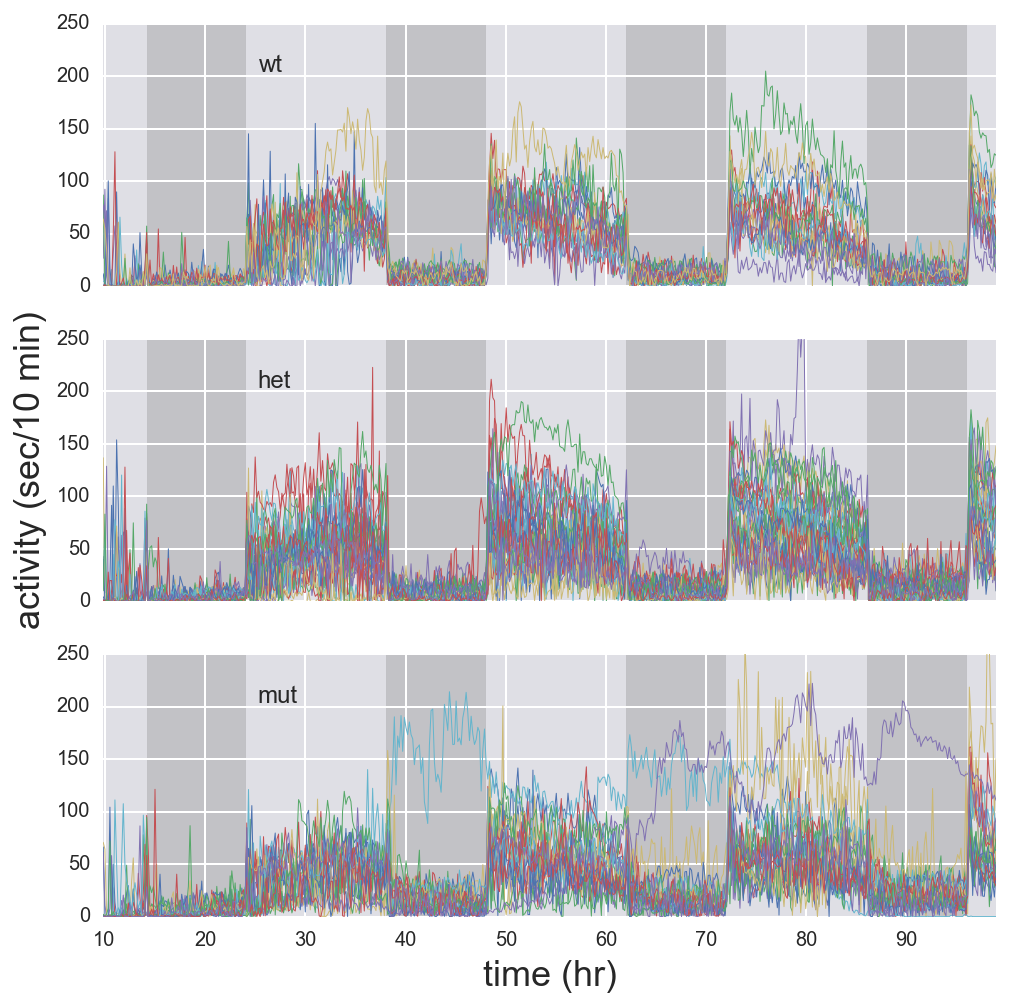

In [5]:
# Set up subplot axes.  We share the y axis to scale all the same.
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, 
                       figsize=(8,8))

# Set ordering of genotypes we want in our plots
gtypes = ['wt', 'het', 'mut']

# Populate each axis with the plots.
for i, gtype in enumerate(gtypes):
    fishes = df.fish[df.genotype==gtype].unique()
    x_label = y_label = ''
    if i == 1:
        y_label = 'activity (sec/10 min)'
    elif i == 2:
        x_label = 'time (hr)'

    ax[i] = pretty_activity_plot(ax[i], 'fish', fishes, 'activity', df, 
                                 lw=0.5, ylabel=y_label, xlabel=x_label)

    ax[i].text(0.175, 0.815, gtype, fontsize=12, transform=ax[i].transAxes)

We see quite a bit of variation from one fish to the next, even with the same genotype.  We also see what appear to be two outlier fish in the homozygous mutant data set that are hyperactive on various nights.

Just eyeballing it, is looks like the mutant fish are a bit more active at night, but it is hard to say.  These activity plots, while useful for visualizing the movements of the fish over time, are less effective for comparing the different genotypes.

To make comparisons, we need to have good metrics for general activity and restfulness.  What these metrics are is something we need to think carefully about.  We will propose and explore various metrics in class, and I present a few candidates below.

## Candidate metrics
<br />

### Mean activity

In the Prober, et al. paper, they compute the mean activity for every time point and plot the results for the various genotypes on the same plot.  We can try that.  To compute the means, we use more of Pandas's `groupby()` magnificence.

In [6]:
# Compute mean activity over fish of given genotype at each time point
mean_activity = df.groupby(('zeit', 'genotype', 'light'))['activity'].mean()

# Take a look
mean_activity.head()

zeit   genotype  light
9.819  het       True      7.900000
       mut       True      9.359091
       wt        True     16.170588
9.986  het       True      4.891176
       mut       True      3.618182
Name: activity, dtype: float64

The result is multi-indexed.  I prefer to work with tidy `DataFrame`s, and our `pretty_activity_plot()` function is designed to work with them.  We can make it into a tidy `DataFrame` by using the `reset_index()` method.

In [7]:
# Tidy it!
mean_activity = mean_activity.reset_index()

# Take a look
mean_activity.head()

,zeit,genotype,light,activity
0,9.819,het,True,7.900000
1,9.819,mut,True,9.359091
2,9.819,wt,True,16.170588
3,9.986,het,True,4.891176
4,9.986,mut,True,3.618182


Now we can make out plots!

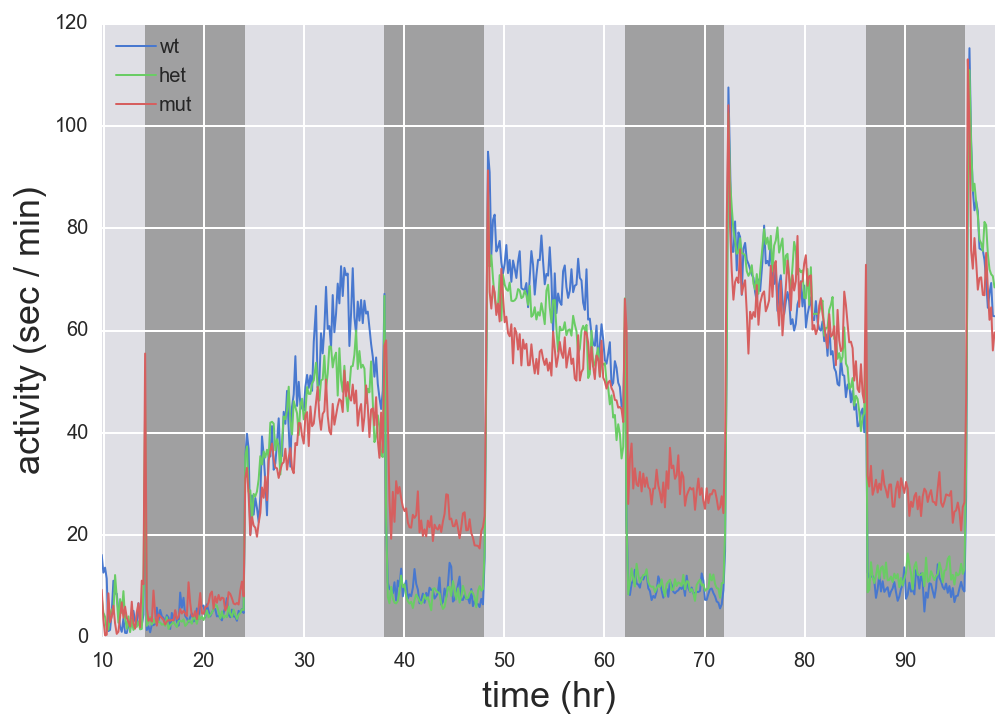

In [8]:
# Plot the result, using muted color palette; shows up better
with sns.color_palette('muted', 3):
    fig, ax = plt.subplots()
    for gtype in gtypes:
        ax = pretty_activity_plot(ax, 'genotype', gtype, 'activity', 
                                  mean_activity,  lw=1)
    plt.legend(('wt', 'het', 'mut'), loc='upper left')

Here, we seem to see a definite difference between nighttime activity of the homozygous mutant and the wild type and heterozygous mutants.

There are some problems with this analysis, though.  First off, we noted before that there were a couple outliers in the mutant data.  This could artificially tug the nighttime activity of the mutant fish up.  What happens if we re-do the averaging, but we throw out the two extreme activity levels at each time point.  (Note: this is not a great way to do outlier detection and correction, as we will talk about later in class.)

We will plot the original curves in a light color and the outlier-adjusted curve in the corresponding darker color.

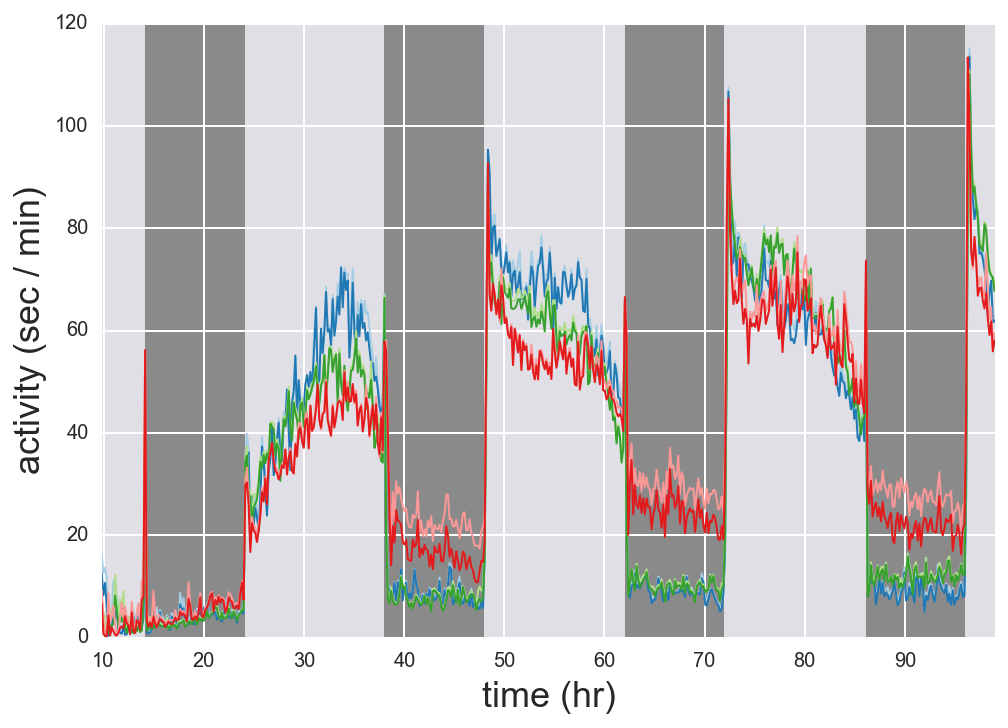

In [9]:
# Calculate useful qtys for each genotype at each time point
grouped_activity = df.groupby(('zeit', 'genotype', 'light'))['activity']
max_act = grouped_activity.max()
min_act = grouped_activity.min()
sum_act = grouped_activity.sum()
n_samples = grouped_activity.count()

# Compute adjusted mean
mean_activity['activity_adj'] = \
    ((sum_act - max_act - min_act) / (n_samples - 2)).reset_index()['activity']

# Plot the result
with sns.color_palette('Paired'):
    fig, ax = plt.subplots()
    for i, gtype in enumerate(gtypes):
        ax = pretty_activity_plot(ax, 'genotype', gtype, 'activity', 
                                  mean_activity,  lw=1,
                                  color=sns.color_palette()[2*i])
        ax = pretty_activity_plot(ax, 'genotype', gtype, 'activity_adj', 
                                  mean_activity,  lw=1,
                                  color=sns.color_palette()[2*i+1])

The outliers really only affect the mutant fish at night.  The mutants still show, on average, substantially more activity at night than the heterozygotis or wild type fish.

### Median activity

We could also plot the median activity over time.  The median is a **robust statistic**, relatively immune to outliers.  So, we compute the median activity for each genotype at each time point.

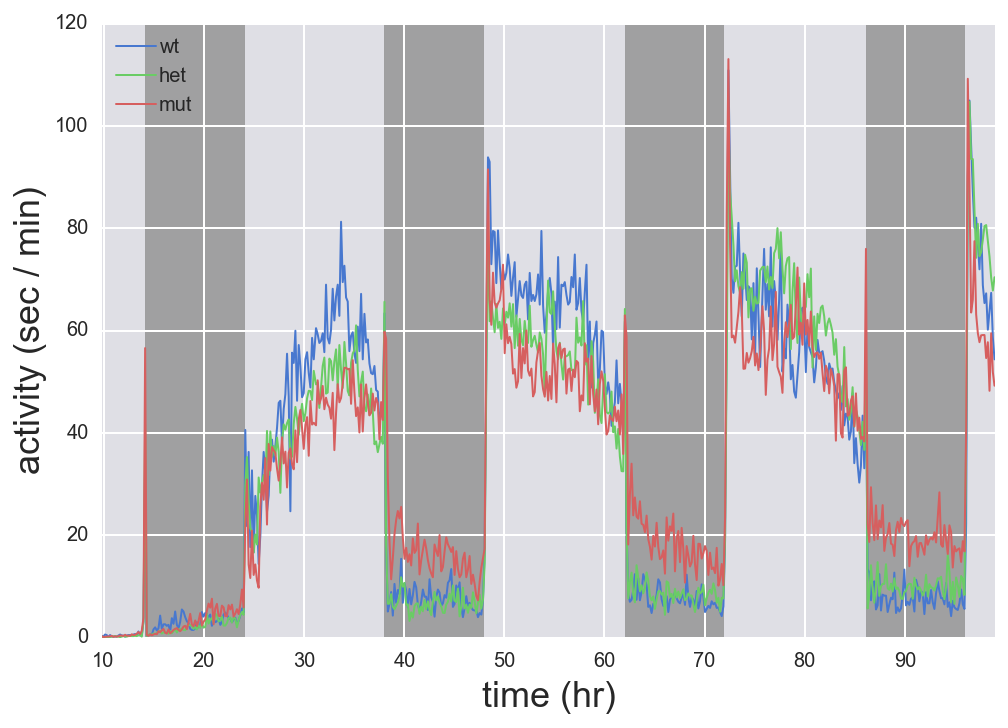

In [10]:
# Compute mean activity over fish of given genotype at each time point
median_activity = df.groupby(
    ('zeit', 'genotype', 'light'))['activity'].median().reset_index()

# Plot the result
with sns.color_palette('muted', 3):
    fig, ax = plt.subplots()
    for gtype in gtypes:
        ax = pretty_activity_plot(ax, 'genotype', gtype, 'activity', 
                                  median_activity,  lw=1)
    plt.legend(('wt', 'het', 'mut'), loc='upper left')

As in the case where we deleted the extreme activities, we see slightly more active nighttime larvae for the homozygous mutants.

Care has to be taken when plotting the mean or median activity over time.  The larval activity data are very "bursty," meaning that the fish are quiescent for stretches of time, and then dart about.  When averaging over many trajectories, we need to make sure that the window of time over which we sum the active minutes is large enough that we get a decent summary of activity.

It is also important to note that no one fish that will have the mean activity nor the median activity for all time.

### Mean daytime and mean nighttime activity

Instead of averaging over trajectories, we could just take the mean activity of each fish for daytime and nighttime and make comparisons.  To make our comparison, let's consider the third night.  Presumably the fish have gotten used to their surroundings.  We can compute the mean nighttime activity of each fish on this night, which we'll call $N_A$ (for "nighttime activity") and make beeswarm plots.

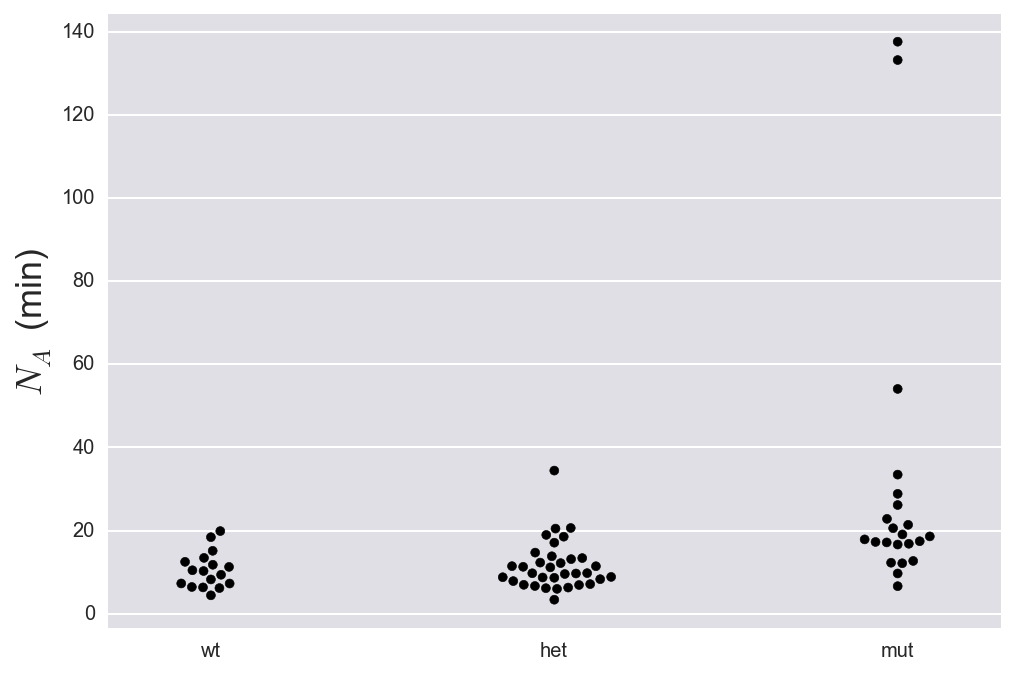

In [11]:
# Get a view into the third night
df_n2 = df[(df['day']==2) & (df['light']==False)]

# Compute means for each fish
mean_night_act = \
        df_n2.groupby(('fish', 'genotype'))['activity'].mean().reset_index()

# Make beeswarm plot
list_of_acts = [mean_night_act.activity[mean_night_act.genotype=='wt'],
                mean_night_act.activity[mean_night_act.genotype=='het'],
                mean_night_act.activity[mean_night_act.genotype=='mut']]

# Generate a beeswarm plot
_ = bs.beeswarm(list_of_acts, labels=['wt', 'het', 'mut'])
plt.grid(axis='x')
plt.ylabel('$N_A$ (min)')

That mutant outliers set the axes so it's hard to see!  Let's resale the $y$-axis to take a better look.

(0, 60)

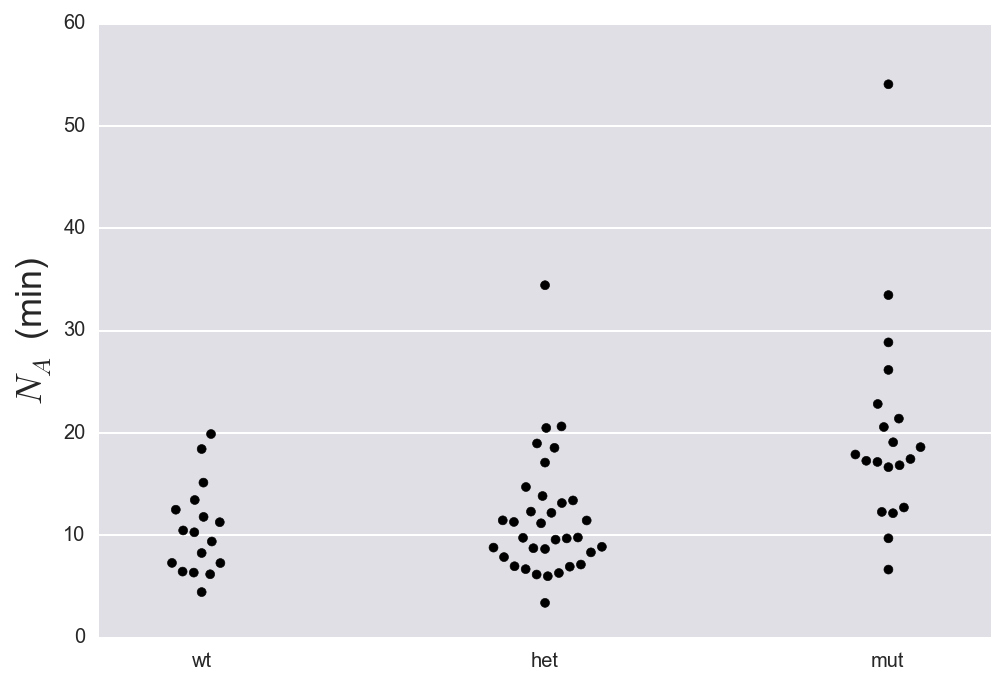

In [12]:
# Redo the plot, but set the reset y limits
_ = bs.beeswarm(list_of_acts, labels=['wt', 'het', 'mut'])
plt.grid(axis='x')
plt.ylabel('$N_A$ (min)')
plt.ylim((0, 60))

We now see that there are subtle differences between the sets (save for the large outliers in the mutant data).  Let's quantify them!

#### Simple Bayesian estimate of the mean

Our measured data are the mean activity over the third night for each fish.  We will not do any extra modeling to get errors for these means, but will instead assume that they all have error coming from a Gaussian distribution with variance $\sigma^2$.  That is to say, we have data that are described by a mean $\mu$ and a variance $\sigma^2$; i.e., each datum is

\begin{align}
x_i = \mu + e_i,
\end{align}

where $e_i$ is the noise component of the $i$th datum.  The noise is assumed to come from a Gaussian distribution with variance $\sigma^2$.  The value of $\sigma$ is the same for all data for a given genotype.  We also assume no prior knowledge about $\mu$ or $\sigma$.

Our goal is to compute $P(\mu~|~D,I)$ for each of the three mutants.  This is the probability that the mean nighttime activity is $\mu$.  The most probable $\mu$ (which is usually the one reported) is where $P(\mu~|~D,I)$ is maximal.

We will derive in lecture on Wednesday (and in section 3.3.1 of Sivia) that in this case, $P(\mu~|~D,I)$ is given by the **Student-t distribution**,

\begin{align}
P(\mu~|~D,I) &\propto \left(1 + \frac{(\mu - \bar{x})^2}{r^2}\right)^{-\frac{n}{2}};\\
r^2 &= \frac{1}{n}\sum_{x_i\in D}(x_i - \bar{x})^2; \\
\bar{x} &= \frac{1}{n}\sum_{x_i\in D}x_i,
\end{align}

where $n = |D|$ is the number of data in $D$.

With this formula in hand, we can compute the posterior distributions for the mean mean nighttime activity of each genotype.  In our case, $x_i$ is $N_{A,i}$, the mean nighttime activity for fish $i$.

We normally don't worry about normalization of the distributions, but it helps for ease of comparison, so we will properly normalize it using a beta function (ratio of gamma functions).

In [13]:
def student_t(mu, x):
    """
    Returns the Student-t distribution for values of mu with data x.
    We could use scipy.stats for this, but we'll do it ourselves.
    """
    # Number of data
    n = len(x)
    
    # Mean of data
    x_mean = x.mean()
    
    # Compute r^2
    r2 = ((x - x_mean)**2).sum() / n
    
    # Compute the mu-dependent part
    t = (1.0 + (mu - x_mean)**2 / r2)**(-n / 2.0)
    
    # Normalize and return
    return -scipy.special.beta(-0.5, n / 2.0) / 2.0 / np.pi / np.sqrt(r2) * t

With this function in hand, we can compute the posterior distributions for $\mu$ for each genotype.

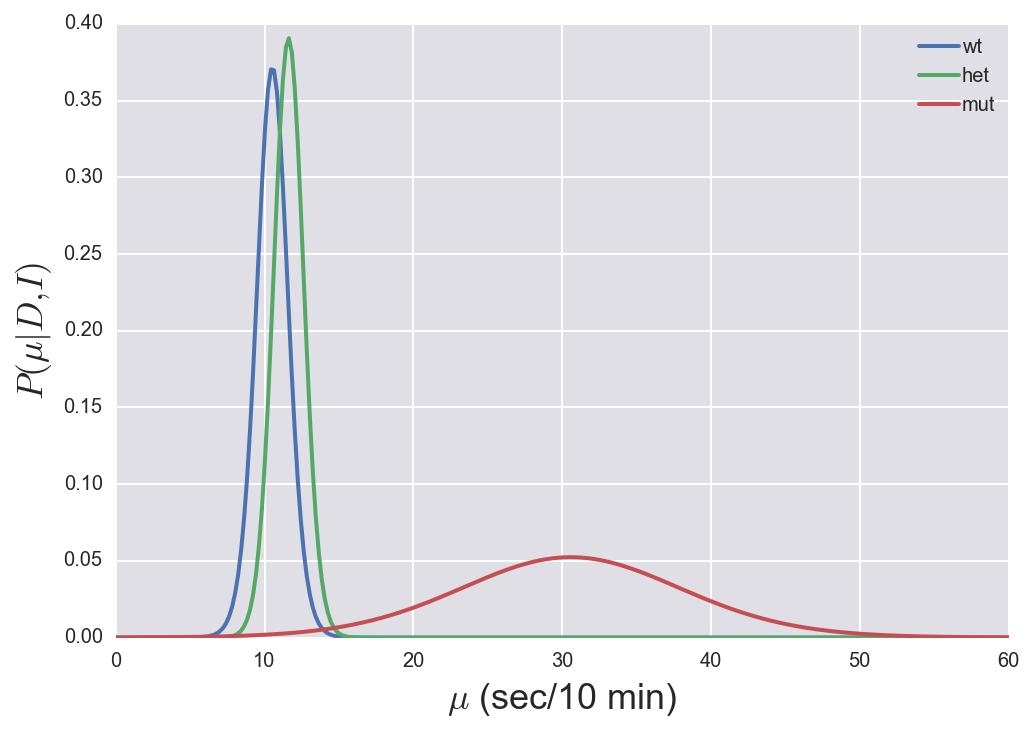

In [14]:
# Set up values of mu to consider in plot
mu = np.linspace(0.0, 60.0, 300)

# Compute posterior for each of the samples
post_wt = student_t(mu, mean_night_act.activity[mean_night_act.genotype=='wt'])
post_het = student_t(mu, mean_night_act.activity[mean_night_act.genotype=='het'])
post_mut = student_t(mu, mean_night_act.activity[mean_night_act.genotype=='mut'])

# Plot the result
plt.plot(mu, post_wt)
plt.plot(mu, post_het)
plt.plot(mu, post_mut)
plt.xlabel(r'$\mu$ (sec/10 min)')
plt.ylabel(r'$P(\mu|D,I)$')
lg = plt.legend(('wt', 'het', 'mut'), loc='upper right')

These posteriors tell a pretty compelling story.  They suggest that the homozygous mutant almost certainly has a higher mean $N_A$ than do the wild type and heterozygous mutants.

But we have to be careful that we interpret exactly what the data say.  First, remember that we assumed that the noise in the experiment was Gaussian distributed.  If this is indeed true, then the two very large levels of activity for the homozygous mutant are real measurements; not outliers.  Remember, $\mu$ is the *mean* $N_A$ for each gentoype.  In the above plot, we are then *only* commenting on the *mean* $N_A$ for the larvae; we *assumed* the distribution of $N_A$ was Gaussian.  Just looking at the data might suggest that some small portion of the homozygous mutants may be prone to being very active at night, but we do not have many data to strongly verify this claim.

If, however, the errors are not strictly Gaussian distributed, it is very possible that the two fish with very large $N_A$ may be outliers.  We will talk about outlier detection and correction later in the class.  For now, just to do a rough investigation, we will see what happens to the posteriors if we delete these two potential outliers.  (While we're doing outlier detection "by eye," we could even say there are three.  Of course, when the number of "outliers" gets large, they're not longer outliers, are they?)

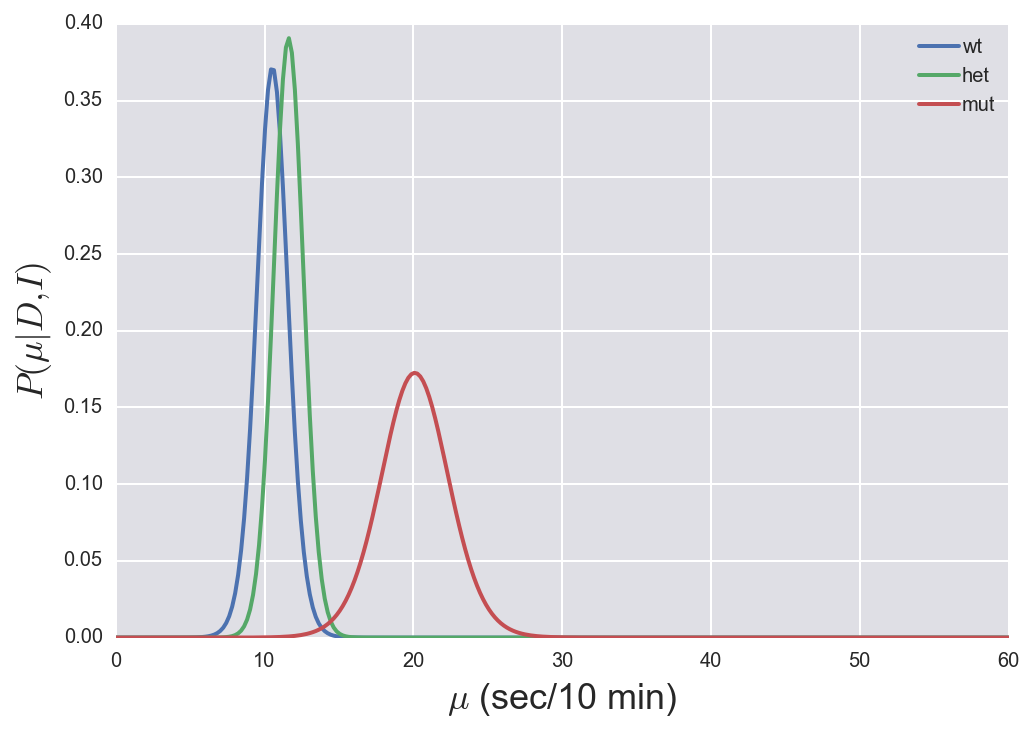

In [15]:
# Set up values of mu to consider
mu = np.linspace(0.0, 60.0, 300)

# Cut out the two largest ones for the mutant
mut_adj = np.sort(mean_night_act.activity[mean_night_act.genotype=='mut'])[:-2]

# Recompute posterior for mutant
post_mut = student_t(mu, mut_adj)

# Plot the result
plt.plot(mu, post_wt)
plt.plot(mu, post_het)
plt.plot(mu, post_mut)
plt.xlabel(r'$\mu$ (sec/10 min)')
plt.ylabel(r'$P(\mu|D,I)$')
lg = plt.legend(('wt', 'het', 'mut'), loc='upper right')

We see that even without these potential outliers, the homozygous mutants still have larger mean $N_A$ than the heterozygous mutants or wild type.

## Bouts

In the Prober, et al. paper, the authors examine "bouts," or extended periods of activity or inactivity.  So, an active bout of length $n$ minutes consists of a fish showing some level of activity during each of $n$ consecutive minutes sampled.  A similar definition applies to rest bouts.  Since the fish move sporadically, bout length might be a good metric for wakefulness.

Since we'll need to compute bout lengths for many samples, we'll write a function to do it.

In [16]:
def bout_lengths(s, wake_threshold=1e-5, rest=True):
    """
    Given activity series s, returns length of rest bouts / length
    of active_bouts if rest is True/False.
    
    First return value is array of rest bout lengths and second return
    value is array of active bout lengths.
    
    The first/last "bouts" are not included because we don't know where
    they begin/end.  The exception is if the fish is always awake or
    asleep.
    """
    # Get Boolean for activeness
    active = (s > wake_threshold)
    
    # Convert to NumPy array if a Pandas Series
    if type(active) is pd.core.series.Series:
        active = active.values
    
    # Check to make sure there is at least one switch
    if np.all(active):
        if rest:
            return np.array([])
        else:
            return np.array([len(s)])
    elif np.all(~active):
        if rest:
            return np.array([len(s)])
        else:
            return np.array([])
 
    # Use the NumPy diff function to find indices where switches states
    # switches[i] is the index of first time point in state it switched to
    switches = np.where(np.diff(active))[0] + 1
    
    # Compute bout lengths from switches, again using np.diff
    bouts = np.diff(switches)
    
    # Find out if active or rest was first and return bout lengths
    # Not most concise way to do it, but most legible
    if active[0]:
        if rest:
            return bouts[::2]
        else:
            return bouts[1::2]
    else:
        if rest:
            return bouts[1::2]
        else:
            return bouts[::2]

Now that we can compute bout lengths, let's look at the sleep bout lengths on the third night.  We will use a wake threshold of zero (and since we're using floating point arithmetic, we set the threshold to be some small value just in case), as in the Prober, et al. paper.  For each fish, we will compute the average length of rest bouts throughout the night.  We use the dense `DataFrame` (activity/minute) for this calculation.

In [17]:
# Get indices for third night
inds = (~df_dense.light) & (df_dense.day==2)

# Group the DataFrame
df_gb = df_dense[inds].groupby(('fish', 'genotype'))['activity']

# Compute the rest bout lengths
df_rest_bout = df_gb.apply(bout_lengths, rest=True).reset_index()

If we look at the new `DataFrame` with rest bouts, we see that the `'activity'` column now has a NumPy array of bout lengths.

In [18]:
df_rest_bout.head()

,fish,genotype,activity
0,FISH1,het,"[1, 3, 3, 1, 5, 1, 2, 3, 4, 2, 3, 1, 4, 1, 1, ..."
1,FISH10,het,"[3, 4, 11, 1, 2, 2, 1, 1, 4, 3, 1, 1, 5, 2, 1,..."
2,FISH11,mut,"[1, 3, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 7, ..."
3,FISH12,mut,"[1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 5, 4, 1, 1, 1, ..."
4,FISH13,mut,"[15, 4, 1, 3, 7, 3, 1, 1, 2, 5, 3, 2, 2, 1, 2,..."


We should rename that column heading to accurately reflect what it contains.

In [19]:
# Rename activity column
df_rest_bout = df_rest_bout.rename(columns={'activity': 'rest_bout_lengths'})

### Mean rest bout lengths

We will now look at the rest bout length as a metric for sleep.  We could consider two types of means.  First, we could take the mean rest bout length for a given fish as being a property of a given fish.  We will henceforth call this the "mean rest bout length."  We then consider the mean of this property for each phenotype.  This is a "mean of means."  As an alternative, we could pool all rest bouts for a given phenotype and consider the mean bout length over all measured rest bouts.  We will call this the "mean of pooled rest bout lengths."

#### Mean of mean rest bout length
We'll start with the mean of means approach.  For convenience, we'll make another column that gives the mean rest bout length for each fish.

In [20]:
# Compute the mean of mean bout lengths
df_rest_bout['mean_rest_bout_length'] = \
                    df_rest_bout['rest_bout_lengths'].map(lambda x: x.mean())
    
# Take a look
df_rest_bout.head()

/Users/Justin/anaconda/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


,fish,genotype,rest_bout_lengths,mean_rest_bout_length
0,FISH1,het,"[1, 3, 3, 1, 5, 1, 2, 3, 4, 2, 3, 1, 4, 1, 1, ...",2.486486
1,FISH10,het,"[3, 4, 11, 1, 2, 2, 1, 1, 4, 3, 1, 1, 5, 2, 1,...",1.700855
2,FISH11,mut,"[1, 3, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 7, ...",2.255556
3,FISH12,mut,"[1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 5, 4, 1, 1, 1, ...",1.529412
4,FISH13,mut,"[15, 4, 1, 3, 7, 3, 1, 1, 2, 5, 3, 2, 2, 1, 2,...",2.373626


We got a warning saying that we took the mean of an empty slice.  This is because two of the mutant fish had no rest bouts.  The `mean()` function then returns NaN.  This means that they will not be included in any plot we make.  We should redefine the mean of an empty array of bout lengths to be zero, as there were no rest bouts.  We can use the `fillna()` method to do this.

In [21]:
# Replace NaNs with zeros
df_rest_bout['mean_rest_bout_length'] \
        = df_rest_bout['mean_rest_bout_length'].fillna(0)

We'll generate beeswarm plots, as for our previous metric of activity.

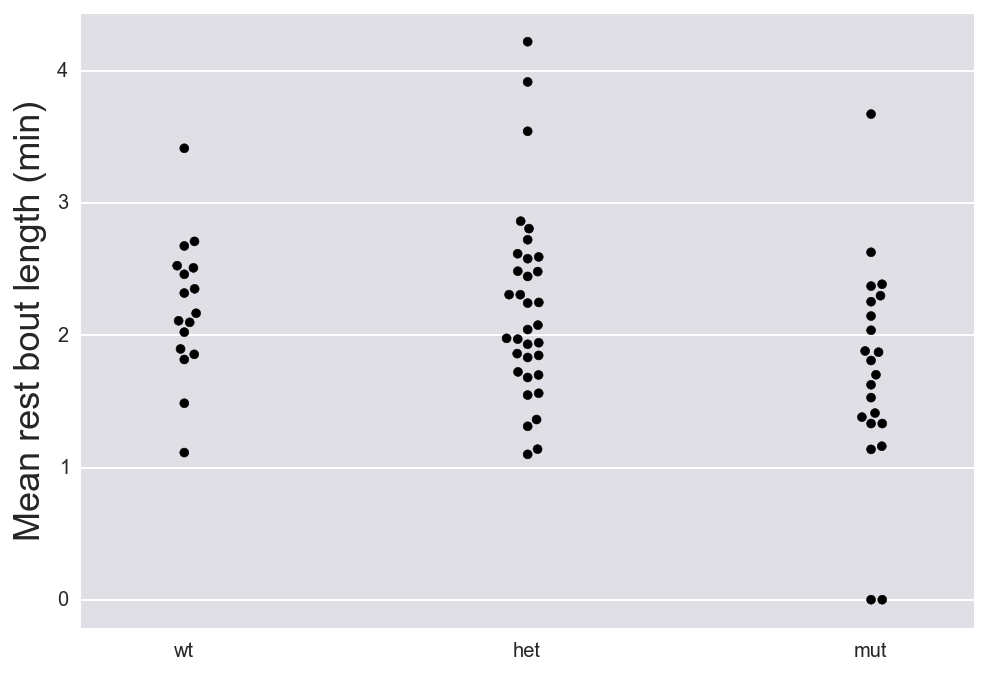

In [22]:
# Make input to beeswarm plot
rest_bouts = []
for gtype in gtypes:
    inds = df_rest_bout.genotype==gtype
    rest_bouts.append(df_rest_bout[inds]['mean_rest_bout_length'].values)

# Generate a beeswarm plot
_ = bs.beeswarm(rest_bouts, labels=['wt', 'het', 'mut'])
plt.grid(axis='x')
plt.ylabel('Mean rest bout length (min)')

Let's plot the posteriors describing the mean of the mean rest bout length.  We will assume that the mean rest bout lengths are Gaussian distributed.  We assume further that they all have the same variance, and that variance is unknown.  This means that again the posterior is a Student-t distribution.  (The mean rest bout lengths actually do not all have the same variance, and we can get good estimates for what it is.  We will not consider that here.)

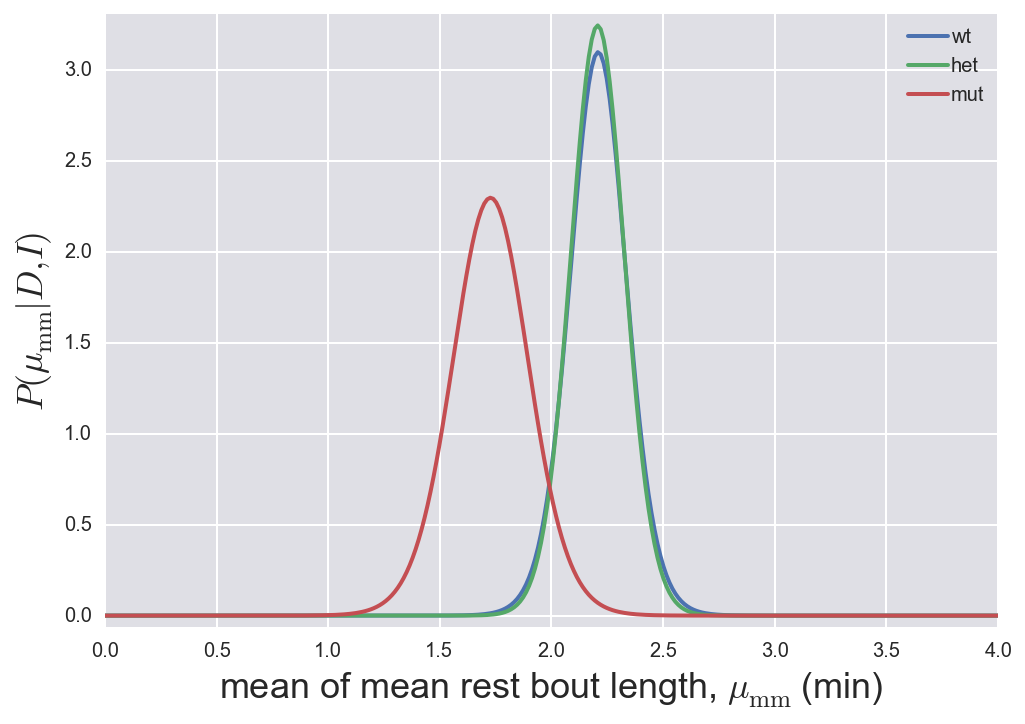

In [23]:
# Set up values of mu to consider
mu = np.linspace(0.0, 4.0, 300)

# Compute posterior for each of the samples
post_wt = student_t(mu, rest_bouts[0])
post_het = student_t(mu, rest_bouts[1])
post_mut = student_t(mu, rest_bouts[2])

# Plot the result
plt.plot(mu, post_wt)
plt.plot(mu, post_het)
plt.plot(mu, post_mut)
plt.margins(y=0.02)
plt.xlabel(r'mean of mean rest bout length, $\mu_\mathrm{mm}$ (min)')
plt.ylabel(r'$P(\mu_\mathrm{mm}|D,I)$')
plt.legend(('wt', 'het', 'mut'), loc='upper right')

We see that the wild type and the heterozygous mutants have slightly longer mean rest bouts than the homozygous mutant, but not by much.  We really could not give a firm conclusion on this.  (However, if we did properly account for the errors in the mean rest bout lengths, we would find these distributions to be narrower, and we would conclude that the mutants sleep less at night.  We leave that as an exercise in [Homework 2](http://bebi103.caltech.edu/2015/homework/hw2.html).)

#### Mean of pooled rest bout lengths
We now want to get a set of *all* rest bouts for each genotype (with all fish pooled together) so that we might then compute the posterior distribution based on them.  Again, we can use some Pandas `groupby()` awesomeness.

In [24]:
# Group the rest bout DataFrame by genotype
df_rest_bout_gb = df_rest_bout.groupby('genotype')['rest_bout_lengths']

# Concatenate the arrays of each genotype
wt_bouts = np.concatenate(df_rest_bout_gb.get_group('wt').values)
het_bouts = np.concatenate(df_rest_bout_gb.get_group('het').values)
mut_bouts = np.concatenate(df_rest_bout_gb.get_group('mut').values)

While it's reasonable to assume that the *mean* rest bout lengths were Gaussian distributed, this may not be the case for all bout lengths.  Indeed, when we plot a histogram of the wild type rest bout lengths, we see that they more closely resemble an exponential distribution.

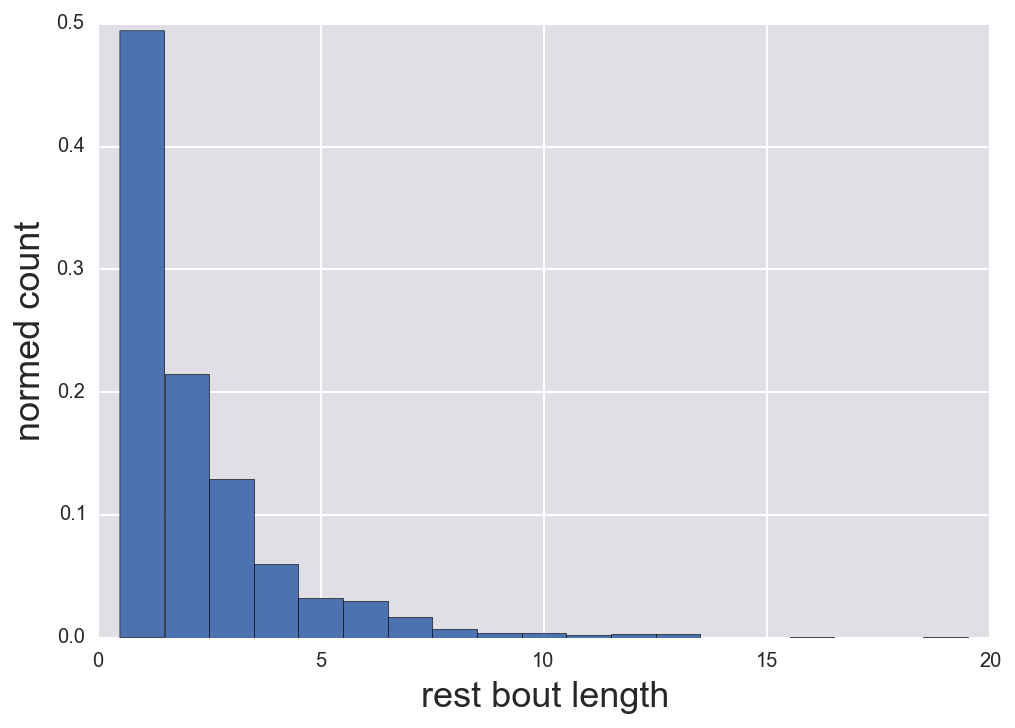

In [25]:
# Set up bins
bins = np.arange(0.5, wt_bouts.max() + 1.5)

# Plot the histograms
_ = plt.hist(wt_bouts, bins=bins, align='mid', normed=True)

# Labels
plt.xlabel('rest bout length')
plt.ylabel('normed count')

As we will learn how to derive in coming lectures and tutorials, if we have exponentially distributed rest bout lengths, the mean pooled bout length, $\lambda$, is distributed as

\begin{align}
P(\lambda \mid D,I) = \frac{a^n}{(n-1)!\,\lambda^{n+1}}\mathrm{e}^{-a/\lambda},
\end{align}

with

\begin{align}
a = \sum_{i\in D} \tau_i,
\end{align}

where $\tau_i$ is the length of rest bout $i$ and $n = |D|$.  We can write a function to compute this probability, though we could use the `scipy.stats` module to do it (since it is a gamma distribution in $a$).

In [26]:
def posterior_exp(lam, tau):
    """
    Posterior probability distribution for exponentially
    distributed waiting times tau.
    """
    n = len(tau)
    a = tau.sum()
    log_dist = n * np.log(a) - (n + 1) * np.log(lam) - a / lam \
             - scipy.special.gammaln(n)

    return np.exp(log_dist)

Now, with the NumPy arrays of bout lengths in hand, we can compute the posterior distribution for each genotype.

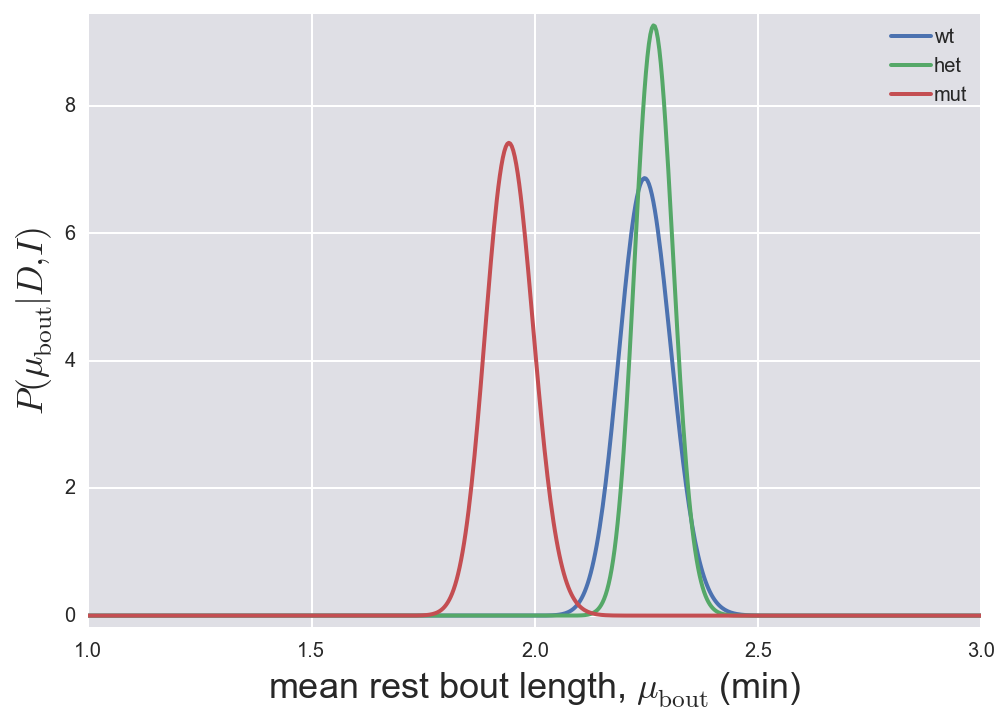

In [27]:
# Set up values of mu to consider
lam = np.linspace(1, 3, 600)

# Compute posterior for each of the samples
post_wt = posterior_exp(lam, wt_bouts)
post_het = posterior_exp(lam, het_bouts)
post_mut = posterior_exp(lam, mut_bouts)

# Plot the result
plt.plot(lam, post_wt)
plt.plot(lam, post_het)
plt.plot(lam, post_mut)
plt.margins(y=0.02)
plt.xlabel(r'mean rest bout length, $\mu_\mathrm{bout}$ (min)')
plt.ylabel(r'$P(\mu_\mathrm{bout}|D,I)$')
plt.legend(('wt', 'het', 'mut'), loc='upper right')

This is clearer. There is no discernible difference between the heterozygotes and the wild type, but the homozygotic mutants have a decidedly smaller mean bount length.  The difference is about 15%.

### Other metrics and estimates

You will propose and evaluate other metrics for restfulness and compute posterior distributions for them in your homework.